# Imports

In [32]:
import numpy as np
import pandas as pd
import nltk
# Text Preprocessing libraries
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import word_tokenize
import re

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Machine Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, GRU, Bidirectional, Embedding, Activation, TextVectorization, Concatenate, SimpleRNN, Conv1D, GlobalMaxPooling1D
from attention import Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import AUC
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TerminateOnNaN
import keras
import keras_tuner
from tensorflow.random import set_seed

# Metrics
from sklearn.metrics import classification_report, roc_curve, confusion_matrix,  auc

# Traning helper functions
from sklearn.model_selection import train_test_split

# Utility Functions
import pickle
import shutil
from tqdm.auto import tqdm # Showing progress bar
tqdm.pandas()

import os

In [2]:
current_path = os.getcwd()
data_path = os.path.join(current_path, 'data')
# import data
imdb_df = pd.read_csv(os.path.join(data_path, 'IMDB Dataset.csv'))

# EDA

In [3]:
imdb_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


sentiment
positive    25000
negative    25000
Name: count, dtype: int64


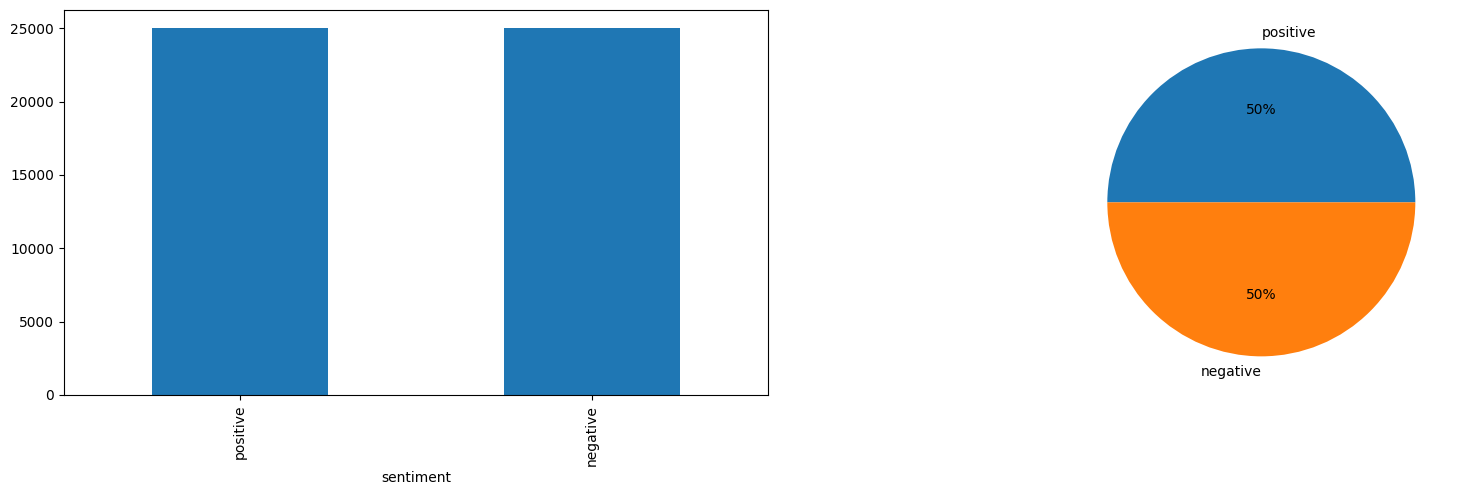

In [4]:
label_info = imdb_df['sentiment'].value_counts()
print(label_info)
plt.figure(figsize=((20,5)))

plt.subplot(1,2,1)
label_info.plot.bar()

plt.subplot(1,2,2)
plt.pie(label_info,labels = label_info.index,autopct='%.0f%%')

plt.show()

# Text-Preproccessing

## Text Cleaning Utility Function

In [6]:
def clean_text(text):
  # Apostrophe
  text = re.sub(r'\x89Ûª', "'", text)
  text = re.sub(r'\x89Û÷', "'", text)

  # Quotation
  text = re.sub(r'\x89ÛÏ', '"', text)
  text = re.sub(r'\x89Û\x9d', '"', text)

  # Hyphen
  text = re.sub(r'\x89ÛÒ', '-', text)
  text = re.sub(r'\x89ÛÓ', '—', text)

  # Euro
  text = re.sub(r'\x89âÂ', '€', text)

  # Ellipsis
  text = re.sub(r'\x89Û_', '...', text)

  # Ampersand
  text = re.sub(r'&', 'and', text)

  # Bullet
  text = re.sub(r"\x89Û¢åÊ", "", text)
  text = re.sub(r'\x89Û¢', '', text)

  # Wrong encodings
  text = re.sub(r"fromåÊwounds", "from wounds", text)
  text = re.sub(r"åÊ", "", text)
  text = re.sub(r"åÈ", "", text)
  text = re.sub(r"JapÌ_n", "Japan", text)
  text = re.sub(r"Ì©", "e", text)
  text = re.sub(r"å¨", "", text)
  text = re.sub(r"SuruÌ¤", "Suruc", text)
  text = re.sub(r"åÇ", "", text)
  text = re.sub(r"å£3million", "3 million ", text)
  text = re.sub(r"åÀ", "", text)

  return text

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'This is a website.',text)

def remove_html(text):
  html=re.compile(r'<.*?>')
  return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Creating Corpus

### Stop Word Removal
Removing common words that don't provide much semantic meanings

In [10]:
imdb_cleaned = imdb_df.copy()
stop_words = stopwords.words('english')
imdb_cleaned['sentiment'] = imdb_cleaned['sentiment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

- The texts will be lowercased
- Short forms will be converted to the right word
- Punctuations will be removed
- The words are stemmed

reference : https://www.kaggle.com/code/quentinsarrazin/tweets-preprocessing/notebook

In [11]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "la" : "los angeles",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [12]:
def to_lower(text):
    return text.lower()

def remove_punc(text):
    return re.sub(r"[^\w\s]","", text)

def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

# Replace all abbreviations
def replace_abbrev(text):
    string = ""
    for word in word_tokenize(text):
        string += word_abbrev(word) + " "        
    return string

def remove_stop_word(text: str):
    stop_words = stopwords.words("english")
    return " ".join(
        [word for word in word_tokenize(text) if word not in (stop_words)]
    )

stemmer = SnowballStemmer("english")
def stem(text):
    return ' '.join([stemmer.stem(word) for word in word_tokenize(text)])

In [13]:
def preprocess_text(input_data):
    r = clean_text(input_data)
    r = remove_URL(r)
    r = remove_html(r)
    r = remove_emoji(r)
    r = to_lower(r)
    r = remove_punc(r)
    r = replace_abbrev(r)
    r = remove_stop_word(r)
    r = stem(r)
    return r

In [14]:
imdb_cleaned['review'] = imdb_cleaned['review'].progress_apply(lambda x: preprocess_text(x))

100%|██████████| 50000/50000 [03:21<00:00, 247.61it/s]


In [15]:
imdb_cleaned.head()

,review,sentiment
0,one review mention watch 1 oz episod youll hoo...,positive
1,wonder littl product film techniqu unassum old...,positive
2,thought wonder way spend time hot summer weeke...,positive
3,basic there famili littl boy jake think there ...,negative
4,petter mattei love time money visual stun film...,positive


## Data Cleaning
- Some of the texts maybe completely blank after preprocessing, need to remove those
- Also removing texts that are shorter than 40 characters which may not provide much information

In [16]:
imdb_cleaned.isnull().sum()

review       0
sentiment    0
dtype: int64

In [17]:
imdb_filtered = imdb_cleaned[imdb_cleaned["review"].str.len() > 40]
imdb_filtered.head()

,review,sentiment
0,one review mention watch 1 oz episod youll hoo...,positive
1,wonder littl product film techniqu unassum old...,positive
2,thought wonder way spend time hot summer weeke...,positive
3,basic there famili littl boy jake think there ...,negative
4,petter mattei love time money visual stun film...,positive


In [18]:
# remove duplicates
imdb_cleaned.drop_duplicates(inplace=True)
imdb_cleaned.reset_index(drop=True, inplace=True)
imdb_cleaned

,review,sentiment
0,one review mention watch 1 oz episod youll hoo...,positive
1,wonder littl product film techniqu unassum old...,positive
2,thought wonder way spend time hot summer weeke...,positive
3,basic there famili littl boy jake think there ...,negative
4,petter mattei love time money visual stun film...,positive
...,...,...
49572,thought movi right good job wasnt creativ orig...,positive
49573,bad plot bad dialogu bad act idiot direct anno...,negative
49574,cathol taught parochi elementari school nun ta...,negative
49575,im go disagre previous comment side maltin one...,negative


49993
sentiment
positive    24999
negative    24994
Name: count, dtype: int64


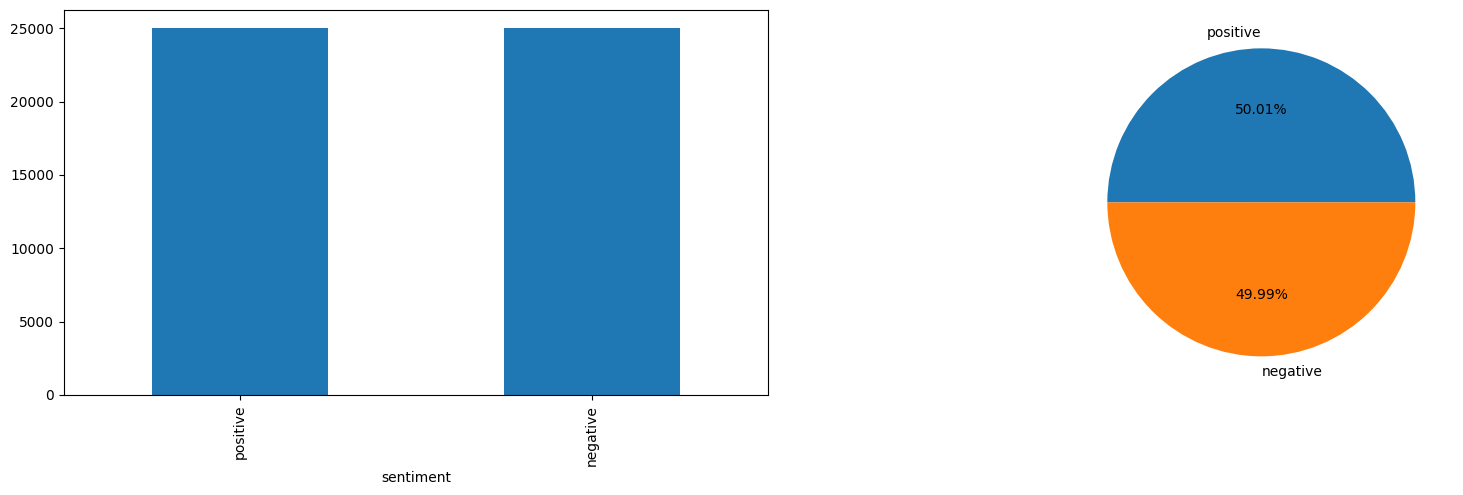

In [19]:
print(len(imdb_filtered))
label_info = imdb_filtered['sentiment'].value_counts()
print(label_info)

plt.figure(figsize=((20,5)))
plt.subplot(1,2,1)
label_info.plot.bar()

plt.subplot(1,2,2)
plt.pie(label_info,labels = label_info.index,autopct='%.2f%%')

plt.show()

## Output Clean intermediate data
Saving the preprocessed data produced into a csv file, allowing the cleaned data to be reaccessed quickly and easily.

In [20]:
imdb_filtered.to_csv("./data/cleaned_IMDB_data.csv", index=False)

In [3]:
imdb_filtered = pd.read_csv("./data/cleaned_IMDB_data.csv")
imdb_filtered.head()

,review,sentiment
0,one review mention watch 1 oz episod youll hoo...,positive
1,wonder littl product film techniqu unassum old...,positive
2,thought wonder way spend time hot summer weeke...,positive
3,basic there famili littl boy jake think there ...,negative
4,petter mattei love time money visual stun film...,positive


# Text Visualization
Visualizes the frequency of the words for each category

## Word Clouds
### Positive Word Cloud

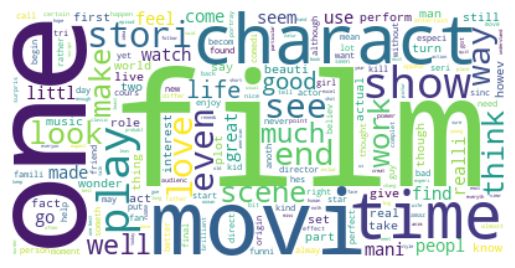

In [21]:
text_positive = " ".join(review for review in imdb_filtered[imdb_filtered["sentiment"] == "positive"]["review"])
wordcloud_positive = WordCloud(background_color="white").generate(text_positive)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis("off")
plt.show()

### Negative Word Cloud

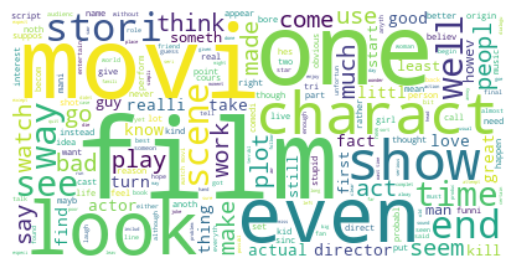

In [22]:
text_negative = " ".join(review for review in imdb_filtered[imdb_filtered["sentiment"] == "negative"]["review"])
wordcloud_negative = WordCloud(background_color="white").generate(text_negative)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis("off")
plt.show()

# Vectorization
Creating a keras layer that vectorizes the texts into tokens

In [4]:
# Configurations: max_features (vocabs), max length (sequence length)
configurations = [(20_000, 500), (20_000, 200), (10_000, 200), (10_000, 500)]

In [11]:
tf.config.list_physical_devices('GPU')

[]

In [25]:
vectorize_layers = [
    TextVectorization(
    max_tokens=max_feat,
    output_mode='int',
    output_sequence_length=max_len)
    for max_feat, max_len in configurations
]

In [26]:
[vectorize_layer.adapt(imdb_filtered['review']) for vectorize_layer in vectorize_layers]

[None, None, None, None]

In [ ]:
# Exporting the vectorize_layer for future use
pickle.dump([{'config': vectorize_layer.get_config(),
             'weights': vectorize_layer.get_weights(),
             'vocabs': vectorize_layer.get_vocabulary(),
             'parameter': configurations[i]} for i, vectorize_layer in enumerate(vectorize_layers)]
            , open("./vectorised_model/vectorizers.pkl", "wb"))

In [10]:
# Importing from disk
from_disk = pickle.load(open("./vectorised_model/vectorizers.pkl", "rb"))

vectorize_layers = [TextVectorization.from_config(val['config']) for val in from_disk]

[vectorize_layer.set_weights(from_disk[i]['weights']) for i, vectorize_layer in enumerate(vectorize_layers)]

[None, None, None, None]

# Modelling

In [12]:
#  change positive sentimanet to 1 and negative to 0
imdb_filtered['sentiment'] = imdb_filtered['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
imdb_filtered

,review,sentiment
0,one review mention watch 1 oz episod youll hoo...,1
1,wonder littl product film techniqu unassum old...,1
2,thought wonder way spend time hot summer weeke...,1
3,basic there famili littl boy jake think there ...,0
4,petter mattei love time money visual stun film...,1
...,...,...
49988,thought movi right good job wasnt creativ orig...,1
49989,bad plot bad dialogu bad act idiot direct anno...,0
49990,cathol taught parochi elementari school nun ta...,0
49991,im go disagre previous comment side maltin one...,0


## Train Test Split

In [13]:
#  train test split
X_train, X_test, y_train, y_test = train_test_split(imdb_filtered['review'],
                                                    imdb_filtered['sentiment'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=imdb_filtered['sentiment'])

In [14]:
print(f"Training data size: {len(y_train)}")
print(f"Testing data size: {len(y_test)}")

Training data size: 39994
Testing data size: 9999


## Helper Functions for Modelling

In [15]:
## This plots the auc against iteration to detect overfitting
def plot_hist(hist, metric='auc'):
    plt.plot(hist.history[metric])
    plt.plot(hist.history["val_" + metric])
    plt.title(f"model performance")
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    return

In [16]:
def plot_confusion_matrix(y_test, y_pred):    
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [17]:
def plot_roc_auc(y_test, y_pred, title = ''):
    """
    Plots a ROC curve with AUC.
    """
    # Compute the false positive rate (FPR), true positive rate (TPR), and thresholds using roc_curve() function
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Compute the area under the ROC curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray',linestyle='--', lw=2, label='Baseline', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

In [18]:
lr = ReduceLROnPlateau(monitor="val_auc", mode='max', factor=0.7, patience=4, verbose=False)
es = EarlyStopping(monitor='val_auc',mode='max', patience=10, verbose=False, restore_best_weights=True)
tn = TerminateOnNaN()

In [20]:
# custom F1 score metric
@keras.saving.register_keras_serializable()
def f1_score(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum(y_pred) - tp
    fn = tf.reduce_sum(y_true) - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    return 2 * precision * recall / (precision + recall)

## Tuning max_features and max_len configurations

In [21]:
# Configurations: max_features (vocabs), max length (sequence length)
configurations = [(20_000, 500), (20_000, 200), (10_000, 200), (10_000, 500)]

## LSTM Model

In [38]:
def create_lstm_tune(units, dropout, lr, embedding_dim, configuration_index):
    max_features, _ = configurations[configuration_index]
    model = Sequential()
    model.add(Input(shape=(1,), dtype=tf.string, name='text'))
    model.add(vectorize_layers[configuration_index])
    model.add(Embedding(max_features + 1, embedding_dim))
    if dropout:
        model.add(Dropout(rate=0.5))
    model.add(LSTM(units=units))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=['accuracy', f1_score, AUC(name="auc")]
    )
    return model


def tune_lstm(hp):
    units = hp.Int("units", min_value=32, max_value=512, step=32)
    vectorize_layer_ind = hp.Int("vectorize config", min_value=0, max_value=3, step=1)
    dropout = hp.Boolean("dropout")
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    embedding_dim = hp.Int("embedding dim", min_value=64, max_value=256, step=32)
    
    # call existing model-building code with the hyperparameter values.
    model = create_lstm_tune(
        units=units, dropout=dropout, lr=lr, configuration_index=vectorize_layer_ind, embedding_dim=embedding_dim
    )
    return model

### Initial Model

In [44]:
initial_lstm_model = create_lstm_tune(units=64, dropout= True, lr=0.005, embedding_dim=128, configuration_index=0)
initial_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 500)               0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 500, 128)          2560128   
                                                                 
 dropout_1 (Dropout)         (None, 500, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2609601 (9.95 MB)
Trainable params: 2609601 (9.95 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [45]:
hist = initial_lstm_model.fit(X_train, y_train, epochs=20, batch_size=128, callbacks=[lr, es], validation_data=(X_test, y_test))

Epoch 1/20


313/313 [==============================] - 158s 500ms/step - loss: 0.6934 - accuracy: 0.5028 - f1_score: nan - auc: 0.5042 - val_loss: 0.6944 - val_accuracy: 0.5001 - val_f1_score: nan - val_auc: 0.5016 - lr: 0.0050
Epoch 2/20
313/313 [==============================] - 161s 514ms/step - loss: 0.6942 - accuracy: 0.5029 - f1_score: nan - auc: 0.5031 - val_loss: 0.7018 - val_accuracy: 0.5001 - val_f1_score: 0.6661 - val_auc: 0.4990 - lr: 0.0050
Epoch 3/20
313/313 [==============================] - 168s 539ms/step - loss: 0.6955 - accuracy: 0.5005 - f1_score: nan - auc: 0.4977 - val_loss: 0.6940 - val_accuracy: 0.4999 - val_f1_score: nan - val_auc: 0.4993 - lr: 0.0050
Epoch 4/20
313/313 [==============================] - 175s 561ms/step - loss: 0.6960 - accuracy: 0.5039 - f1_score: nan - auc: 0.5059 - val_loss: 0.6932 - val_accuracy: 0.4999 - val_f1_score: nan - val_auc: 0.4995 - lr: 0.0050
Epoch 5/20
313/313 [==============================] - 182s 581ms/step - loss: 0.6956 - accuracy: 0.5

#### Model Testing

In [46]:
# Classification Report and Confusion Matrix
y_pred = initial_lstm_model.predict(X_test)
y_pred = np.round(y_pred)
print(classification_report(y_test, y_pred))

313/313 [==============================] - 13s 40ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      4999
           1       0.56      0.00      0.00      5000

    accuracy                           0.50      9999
   macro avg       0.53      0.50      0.33      9999
weighted avg       0.53      0.50      0.33      9999



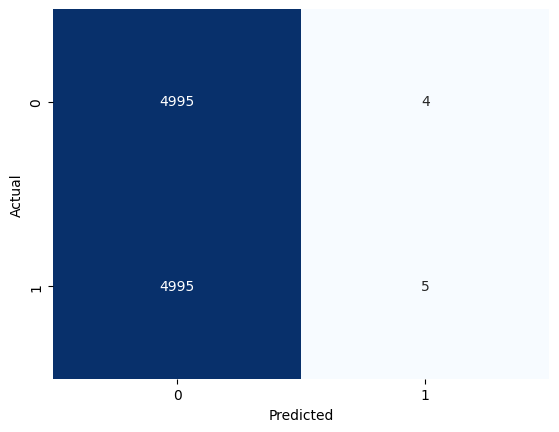

In [47]:
plot_confusion_matrix(y_test, y_pred)

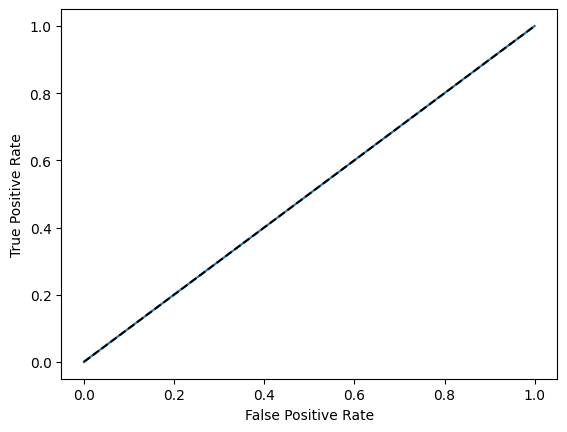

In [48]:
plot_roc_auc(y_test, y_pred)

#### Model history

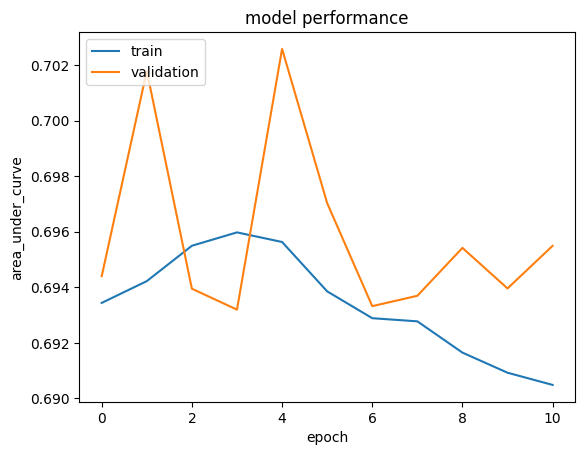

In [49]:
plot_hist(hist, metric='loss')

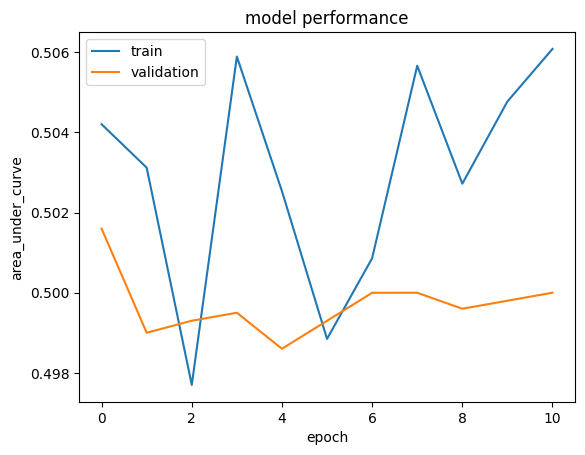

In [50]:
plot_hist(hist)

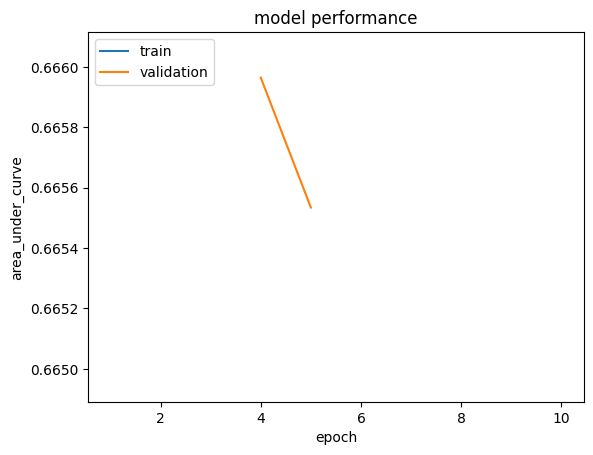

In [51]:
plot_hist(hist, metric='f1_score')

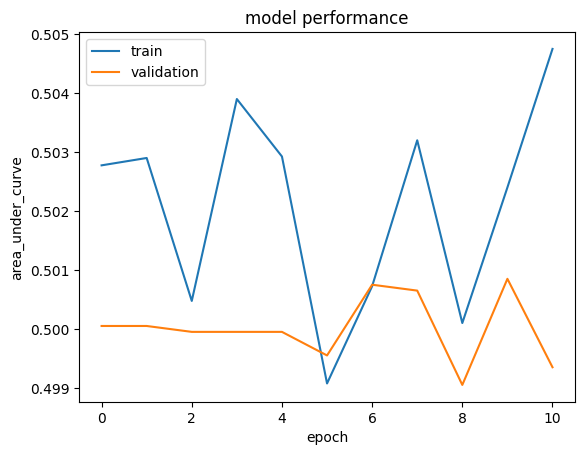

In [52]:
plot_hist(hist, metric='accuracy')

### Hyperparameter Tuning

In [54]:
tuner_lstm = keras_tuner.RandomSearch(
    hypermodel=tune_lstm,
    objective=keras_tuner.Objective("val_auc", "max"),
    max_trials=10,
    executions_per_trial=2,
    overwrite=False,
    directory="./working",
    project_name="lstm",
)

tuner_lstm.search(X_train, y_train, epochs=6, validation_data=(X_test, y_test), callbacks=[es,lr, tn])

print(tuner_lstm.get_best_models()[0].summary())

best_hps=tuner_lstm.get_best_hyperparameters(num_trials=1)[0]

Trial 10 Complete [11h 21m 47s]
val_auc: 0.7285332679748535

Best val_auc So Far: 0.9502452909946442
Total elapsed time: 13h 32m 39s
INFO:tensorflow:Oracle triggered exit


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (Text  (None, 200)               0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 200, 128)          1280128   
                                                                 
 dropout (Dropout)           (None, 200, 128)          0         
                                                                 
 lstm (LSTM)                 (None, 96)                86400     
                                                                 
 dense (Dense)               (None, 1)                 97        
                                                                 
Total params: 1366625 (5.21 MB)
Trainable params: 1366625 (5.21 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

#### Build Tuned Model

In [120]:
## Training the best model
best_lstm = tuner_lstm.get_best_models()[0]
best_lstm.build(X_train.shape)
hist = best_lstm.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[es,lr, tn])

Epoch 1/10
1250/1250 [==============================] - 270s 214ms/step - loss: 0.1613 - accuracy: 0.9399 - f1_score: 0.9383 - auc: 0.9832 - val_loss: 0.2996 - val_accuracy: 0.8829 - val_f1_score: 0.8778 - val_auc: 0.9517 - lr: 0.0039
Epoch 2/10
1250/1250 [==============================] - 252s 202ms/step - loss: 0.1341 - accuracy: 0.9512 - f1_score: 0.9499 - auc: 0.9880 - val_loss: 0.3343 - val_accuracy: 0.8818 - val_f1_score: 0.8808 - val_auc: 0.9493 - lr: 0.0039
Epoch 3/10
1250/1250 [==============================] - 259s 207ms/step - loss: 0.1166 - accuracy: 0.9579 - f1_score: 0.9569 - auc: 0.9909 - val_loss: 0.3465 - val_accuracy: 0.8774 - val_f1_score: 0.8762 - val_auc: 0.9469 - lr: 0.0039
Epoch 4/10
1250/1250 [==============================] - 254s 203ms/step - loss: 0.1023 - accuracy: 0.9628 - f1_score: 0.9615 - auc: 0.9926 - val_loss: 0.3675 - val_accuracy: 0.8774 - val_f1_score: 0.8745 - val_auc: 0.9449 - lr: 0.0039
Epoch 5/10
1250/1250 [==============================] - 254s

##### Tuned Model History

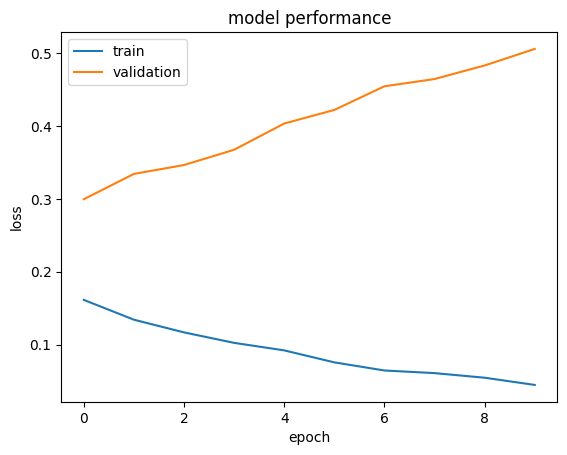

In [121]:
plot_hist(hist, metric='loss')

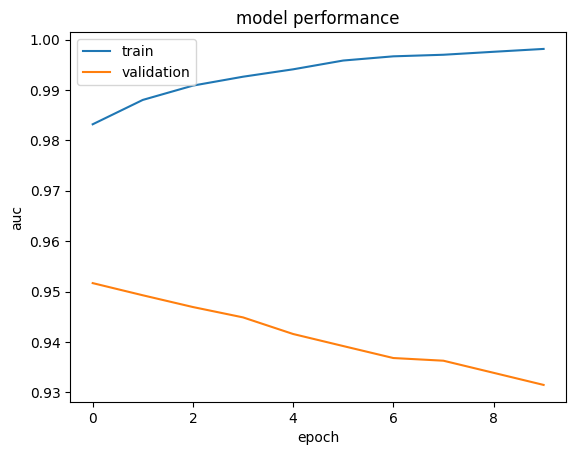

In [122]:
plot_hist(hist)

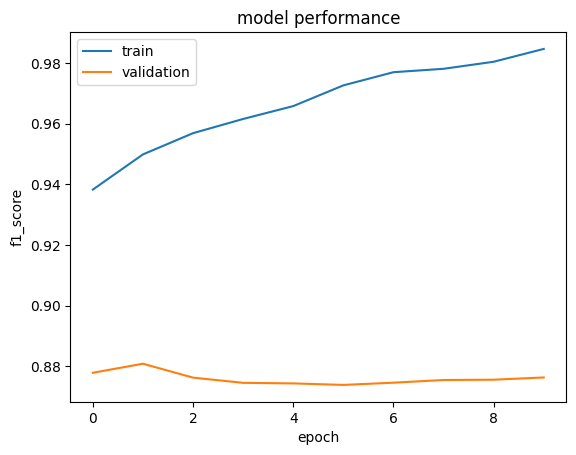

In [123]:
plot_hist(hist, metric='f1_score')

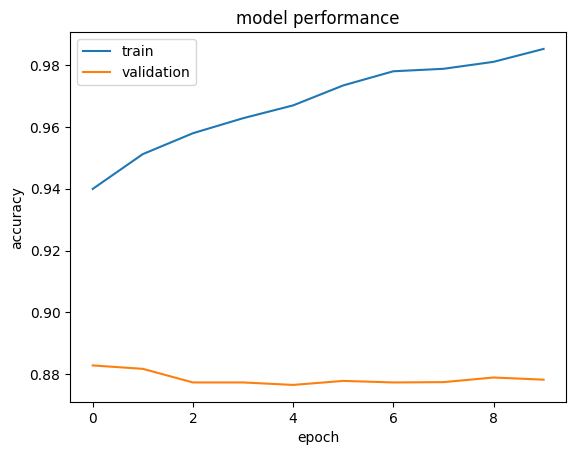

In [124]:
plot_hist(hist, metric='accuracy')

 - History shows that epoch 0 (model that is from the tuner), is the best as after that it starts to overfit.

##### Tuned Model Testing

In [111]:
best_lstm = tuner_lstm.get_best_models()[0]
# Classification Report and Confusion Matrix
y_pred = best_lstm.predict(X_test)
y_pred = np.round(y_pred)
print(classification_report(y_test, y_pred))

313/313 [==============================] - 13s 39ms/step
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      4999
           1       0.89      0.89      0.89      5000

    accuracy                           0.89      9999
   macro avg       0.89      0.89      0.89      9999
weighted avg       0.89      0.89      0.89      9999



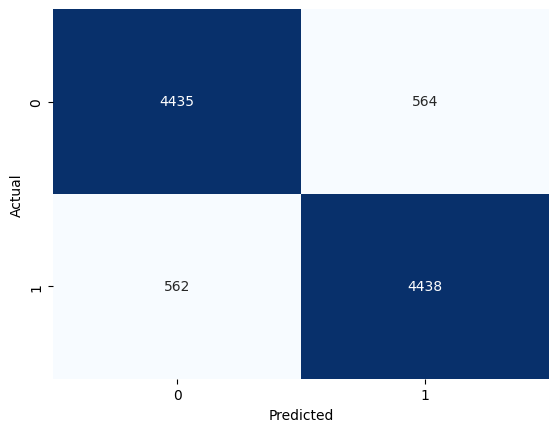

In [112]:
plot_confusion_matrix(y_test, y_pred)

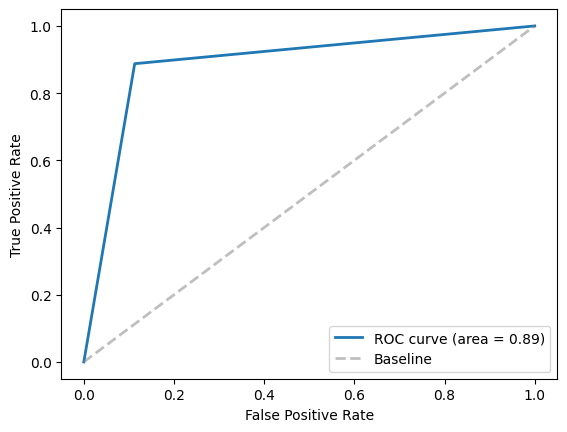

In [113]:
plot_roc_auc(y_test, y_pred)

In [114]:
#  save model 
best_lstm.save("./models/best_lstm_model")

INFO:tensorflow:Assets written to: ./models/best_lstm_model\assets


INFO:tensorflow:Assets written to: ./models/best_lstm_model\assets


## CNN-1D Model

### Initial Model

In [64]:
# create CNN model
def create_CNN1D(config_index):
    max_features, _ = configurations[config_index]
    model = Sequential()
    model.add(Input(shape=(1,), dtype=tf.string, name='text_input'))
    model.add(vectorize_layers[config_index])
    model.add(Embedding(max_features + 1, 128))
    model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
    model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    
    return model

In [65]:
CNN1D = create_CNN1D(0)

# Compile the model
CNN1D.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1_score, AUC()])

CNN1D.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 500)               0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 500, 128)          2560128   
                                                                 


 conv1d (Conv1D)             (None, 165, 128)          114816    
                                                                 
 conv1d_1 (Conv1D)           (None, 53, 128)           114816    
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2806401 (10.71 MB)
Trainable params: 2806401 (10.71 MB)
Non-trainable params: 0 (0.00 Byte)
____________________________________

In [66]:
hist = CNN1D.fit(X_train, y_train, epochs=20, batch_size=128, callbacks=[lr, es], validation_data=(X_test, y_test))

Epoch 1/20
313/313 [==============================] - 30s 94ms/step - loss: 0.3894 - accuracy: 0.8066 - f1_score: 0.7964 - auc: 0.9038 - val_loss: 0.2686 - val_accuracy: 0.8869 - val_f1_score: 0.8857 - val_auc: 0.9565 - lr: 0.0010
Epoch 2/20
313/313 [==============================] - 29s 92ms/step - loss: 0.1805 - accuracy: 0.9323 - f1_score: 0.9320 - auc: 0.9794 - val_loss: 0.2864 - val_accuracy: 0.8893 - val_f1_score: 0.8878 - val_auc: 0.9537 - lr: 0.0010
Epoch 3/20
313/313 [==============================] - 29s 92ms/step - loss: 0.0658 - accuracy: 0.9779 - f1_score: 0.9777 - auc: 0.9965 - val_loss: 0.4054 - val_accuracy: 0.8742 - val_f1_score: 0.8710 - val_auc: 0.9427 - lr: 0.0010
Epoch 4/20
313/313 [==============================] - 29s 91ms/step - loss: 0.0255 - accuracy: 0.9913 - f1_score: 0.9912 - auc: 0.9994 - val_loss: 0.5668 - val_accuracy: 0.8741 - val_f1_score: 0.8756 - val_auc: 0.9301 - lr: 0.0010
Epoch 5/20
313/313 [==============================] - 28s 91ms/step - loss: 

#### Model Testing

In [67]:
# Classification Report and Confusion Matrix
y_pred = CNN1D.predict(X_test)
y_pred = np.round(y_pred)
print(classification_report(y_test, y_pred))

  8/313 [..............................] - ETA: 2s 

313/313 [==============================] - 3s 9ms/step
              precision    recall  f1-score   support

           0       0.88      0.89      0.89      4999
           1       0.89      0.88      0.89      5000

    accuracy                           0.89      9999
   macro avg       0.89      0.89      0.89      9999
weighted avg       0.89      0.89      0.89      9999



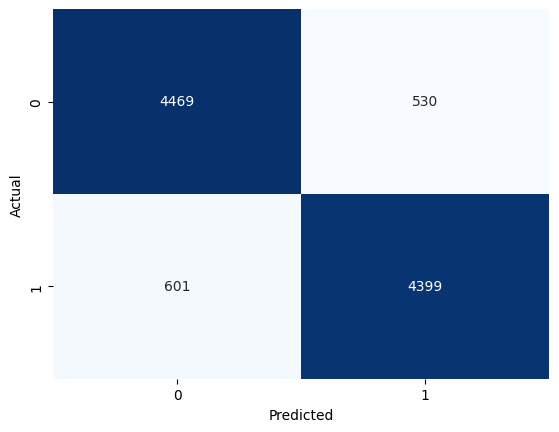

In [68]:
plot_confusion_matrix(y_test, y_pred)

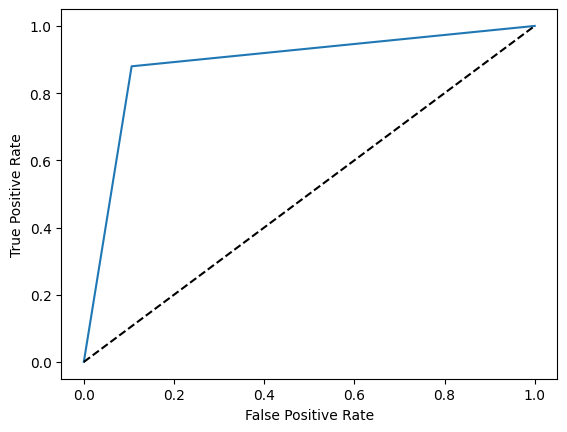

In [69]:
plot_roc_auc(y_test, y_pred)

#### Model History

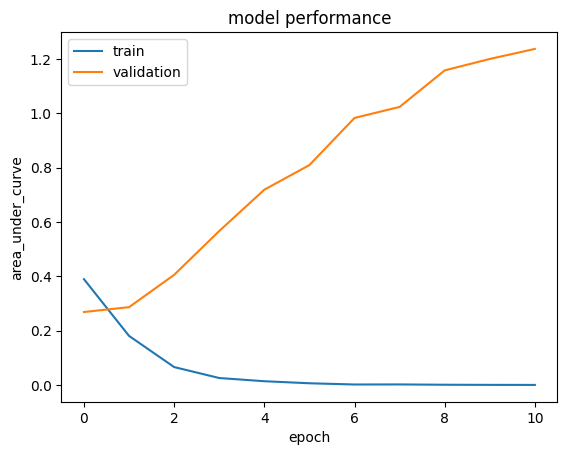

In [70]:
plot_hist(hist, metric='loss')

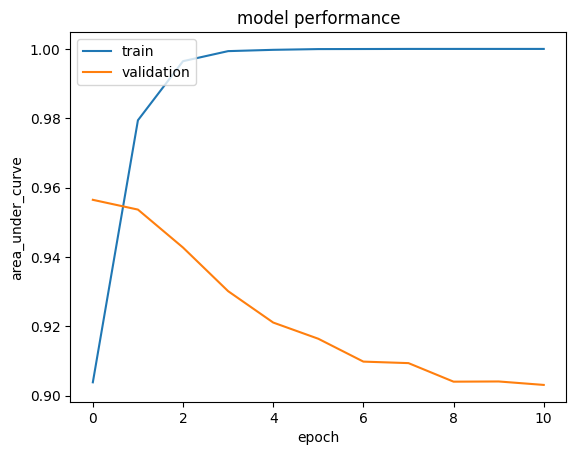

In [71]:
plot_hist(hist)

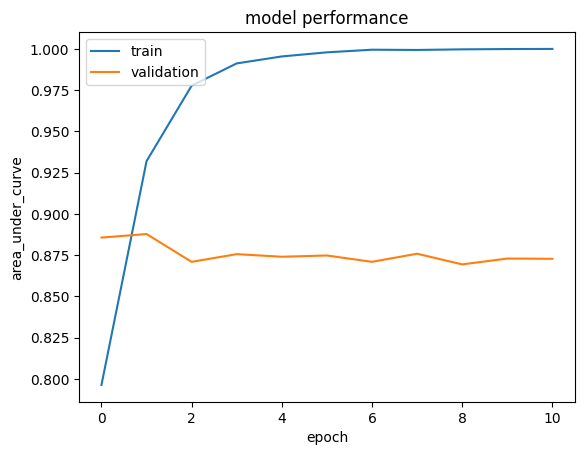

In [72]:
plot_hist(hist, metric='f1_score')

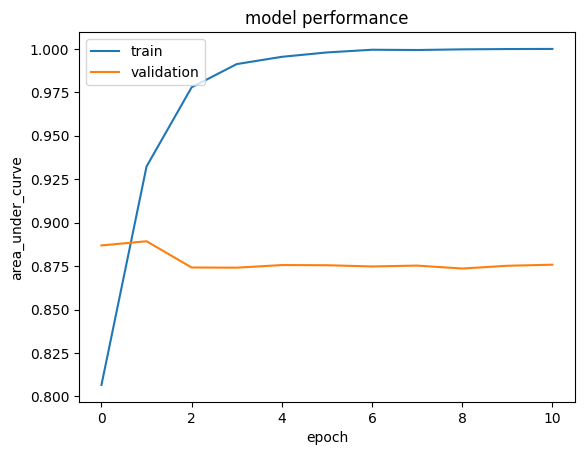

In [73]:
plot_hist(hist, metric='accuracy')

### Hyperparameter Tuning

In [74]:
def create_CNN1D_tune(embedding_dim, configuration_index, dropout, lr, number_of_cnn1d_layers, cnn1d_filters, cnn1d_kernel_size, strides):
    max_features, _ = configurations[configuration_index]
    model = Sequential()
    model.add(Input(shape=(1,), dtype=tf.string, name='text_input'))
    model.add(vectorize_layers[configuration_index])
    model.add(Embedding(max_features + 1, embedding_dim))
    for _ in range(number_of_cnn1d_layers):
        model.add(Conv1D(cnn1d_filters, cnn1d_kernel_size, padding="valid", activation="relu", strides= strides))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=['accuracy', f1_score, AUC(name="auc")]
    )
    return model

def tune_CNN1D(hp):
    vectorize_layer_ind = hp.Choice("vectorize config", values=[0, 1, 2, 3])
    dropout = hp.Float("dropout", min_value=0, max_value=0.5, step=0.1)
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    embedding_dim = hp.Int("embedding dim", min_value=64, max_value=256, step=32)
    number_of_cnn1d_layers = hp.Int("number of cnn1d layers", min_value=1, max_value=3, step=1)
    cnn1d_filters = hp.Choice("cnn1d filters", values=[64, 128, 256])
    cnn1d_kernel_size = hp.Int("cnn1d kernel size", min_value=3, max_value=7, step=2)
    strides = hp.Int("strides", min_value=1, max_value=3, step=1)
    
    model = create_CNN1D_tune(
        embedding_dim=embedding_dim, configuration_index=vectorize_layer_ind, dropout=dropout, lr=lr, 
        number_of_cnn1d_layers=number_of_cnn1d_layers, cnn1d_filters=cnn1d_filters, cnn1d_kernel_size=cnn1d_kernel_size, strides=strides
    )
    return model

In [85]:
tuner_CNN1D = keras_tuner.RandomSearch(
    hypermodel=tune_CNN1D,
    objective=keras_tuner.Objective("val_auc", "max"),
    max_trials=30,
    executions_per_trial=2,
    overwrite=False,
    directory="./working",
    project_name="cnn1d",
)

tuner_CNN1D.search(X_train, y_train, epochs=6, validation_data=(X_test, y_test), callbacks=[es,lr, tn])

print(tuner_CNN1D.get_best_models()[0].summary())
#  get best hyperparameters
best_hps=tuner_CNN1D.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 27m 57s]
val_auc: 0.9584311246871948

Best val_auc So Far: 0.9612913131713867
Total elapsed time: 06h 36m 43s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 500)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 500, 160)          3200160   
                                                                 
 conv1d (Conv1D)             (None, 165, 128)          143488    
                                                                 
 conv1d_1 (Conv1D)           (None, 53, 128)           114816    
                                                                 
 conv1d_2 (Conv1D)           (None, 16, 128)           114816    
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                        

None


#### Build Tuned Model

In [125]:
## Training the best model
best_CNN1D = tuner_CNN1D.get_best_models()[0]
best_CNN1D.build(X_train.shape)
hist = best_CNN1D.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[es,lr, tn])

Epoch 1/10
1250/1250 [==============================] - 78s 62ms/step - loss: 0.1625 - accuracy: 0.9398 - f1_score: 0.9378 - auc: 0.9833 - val_loss: 0.2838 - val_accuracy: 0.8907 - val_f1_score: 0.8889 - val_auc: 0.9549 - lr: 7.9487e-04
Epoch 2/10
1250/1250 [==============================] - 76s 61ms/step - loss: 0.0528 - accuracy: 0.9828 - f1_score: 0.9822 - auc: 0.9975 - val_loss: 0.5401 - val_accuracy: 0.8634 - val_f1_score: 0.8498 - val_auc: 0.9341 - lr: 7.9487e-04
Epoch 3/10
1250/1250 [==============================] - 76s 60ms/step - loss: 0.0263 - accuracy: 0.9910 - f1_score: 0.9909 - auc: 0.9991 - val_loss: 0.7434 - val_accuracy: 0.8542 - val_f1_score: 0.8376 - val_auc: 0.9204 - lr: 7.9487e-04
Epoch 4/10
1250/1250 [==============================] - 76s 60ms/step - loss: 0.0162 - accuracy: 0.9944 - f1_score: 0.9941 - auc: 0.9995 - val_loss: 0.8010 - val_accuracy: 0.8757 - val_f1_score: 0.8702 - val_auc: 0.9209 - lr: 7.9487e-04
Epoch 5/10
1250/1250 [==============================

##### Tuned Model History

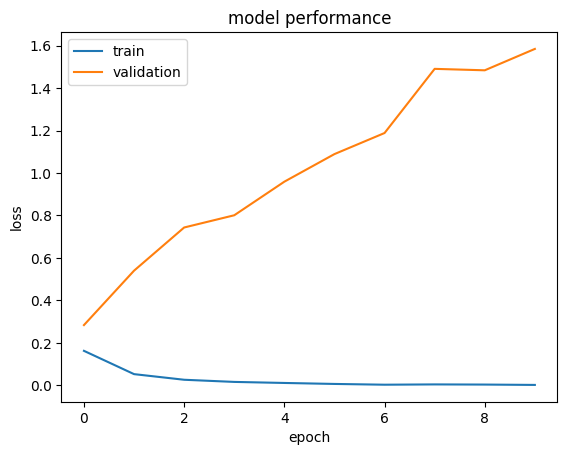

In [126]:
plot_hist(hist, metric='loss')

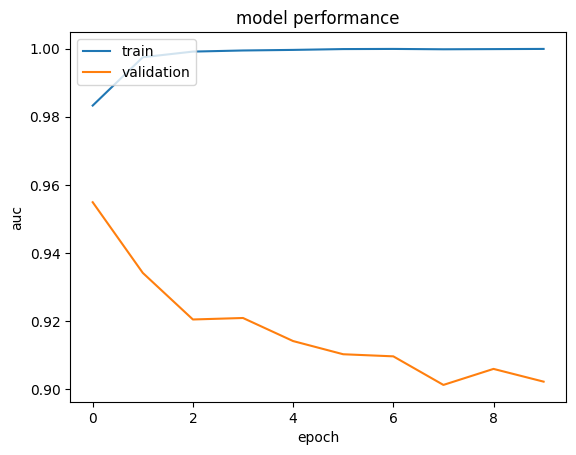

In [127]:
plot_hist(hist)

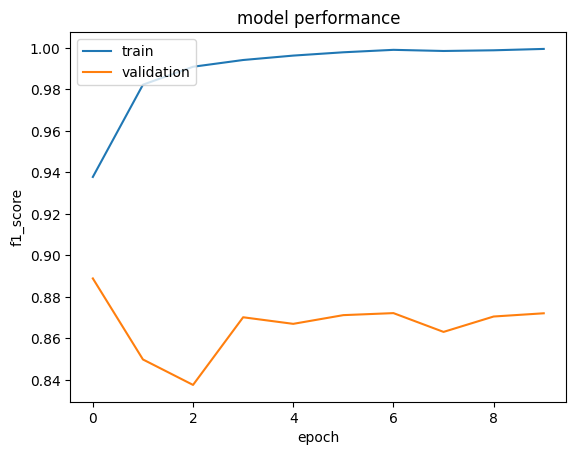

In [128]:
plot_hist(hist, metric='f1_score')

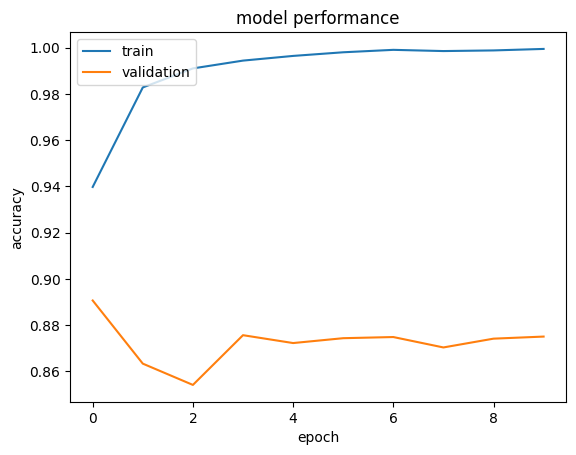

In [129]:
plot_hist(hist, metric='accuracy')

 - History shows that epoch 0 (model that is from the tuner), is the best as after that it starts to overfit.

##### Tuned Model Testing

In [115]:
best_CNN1D = tuner_CNN1D.get_best_models()[0]
# Classification Report and Confusion Matrix
y_pred = best_CNN1D.predict(X_test)
y_pred = np.round(y_pred)
print(classification_report(y_test, y_pred))

313/313 [==============================] - 5s 17ms/step
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      4999
           1       0.89      0.92      0.90      5000

    accuracy                           0.90      9999
   macro avg       0.90      0.90      0.90      9999
weighted avg       0.90      0.90      0.90      9999



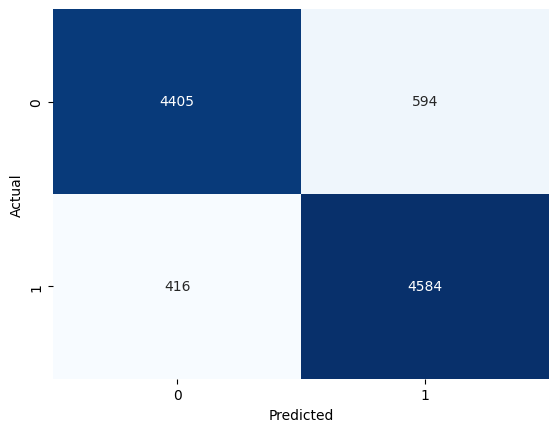

In [116]:
plot_confusion_matrix(y_test, y_pred)

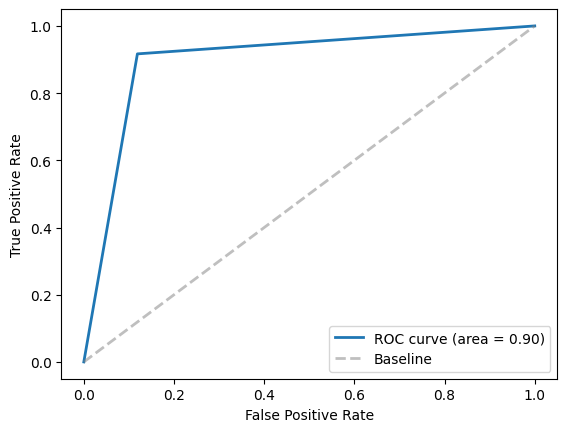

In [117]:
plot_roc_auc(y_test, y_pred)

In [118]:
#  save model 
best_CNN1D.save("./models/best_cnn1d_model")

INFO:tensorflow:Assets written to: ./models/best_cnn1d_model\assets


INFO:tensorflow:Assets written to: ./models/best_cnn1d_model\assets


## RNN

### Initial Model

In [ ]:
# Create RNN model
def create_RNN(config_index):
    max_features, _ = configurations[config_index]
    model = Sequential()
    model.add(Input(shape=(1,), dtype=tf.string, name='text'))
    model.add(vectorize_layers[config_index])
    model.add(Embedding(max_features + 1, 128))
    model.add(SimpleRNN(128))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    
    return model

In [ ]:
RNN = create_RNN(0)

# Compile the model
RNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1_score, AUC(name="auc")])

RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 500)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 500, 128)          2560128   
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2593153 (9.89 MB)
Trainable params: 2593153 (9.89 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [ ]:
hist = RNN.fit(X_train, y_train, epochs=20, batch_size=128, callbacks=[lr, es], validation_data=(X_test, y_test))

Epoch 1/20
313/313 [==============================] - 133s 418ms/step - loss: 0.7313 - accuracy: 0.4980 - f1_score: 0.4947 - auc: 0.4976 - val_loss: 0.6963 - val_accuracy: 0.5043 - val_f1_score: 0.3943 - val_auc: 0.5060 - lr: 0.0010
Epoch 2/20
313/313 [==============================] - 129s 413ms/step - loss: 0.7101 - accuracy: 0.4994 - f1_score: 0.4982 - auc: 0.4974 - val_loss: 0.6940 - val_accuracy: 0.5050 - val_f1_score: 0.4512 - val_auc: 0.5041 - lr: 0.0010
Epoch 3/20
313/313 [==============================] - 133s 426ms/step - loss: 0.6964 - accuracy: 0.5035 - f1_score: 0.4951 - auc: 0.5042 - val_loss: 0.6944 - val_accuracy: 0.5013 - val_f1_score: 0.5611 - val_auc: 0.5041 - lr: 0.0010
Epoch 4/20
313/313 [==============================] - 156s 498ms/step - loss: 0.6956 - accuracy: 0.4974 - f1_score: 0.4811 - auc: 0.4979 - val_loss: 0.6945 - val_accuracy: 0.4982 - val_f1_score: 0.4142 - val_auc: 0.5009 - lr: 0.0010
Epoch 5/20
313/313 [==============================] - 151s 483ms/ste

#### Model Testing

In [ ]:
# Classification Report and Confusion Matrix
y_pred = RNN.predict(X_test)
y_pred = np.round(y_pred)
print(classification_report(y_test, y_pred))

313/313 [==============================] - 15s 45ms/step
              precision    recall  f1-score   support

           0       0.50      0.68      0.58      4999
           1       0.51      0.33      0.40      5000

    accuracy                           0.50      9999
   macro avg       0.50      0.50      0.49      9999
weighted avg       0.50      0.50      0.49      9999



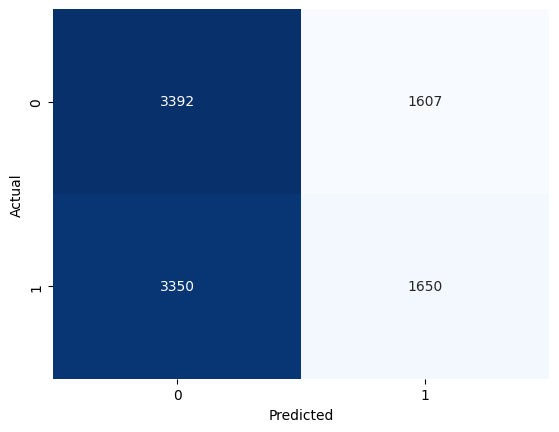

In [ ]:
plot_confusion_matrix(y_test, y_pred)

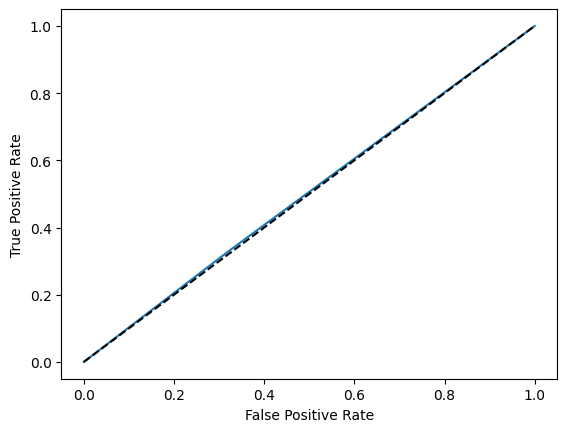

In [ ]:
plot_roc_auc(y_test, y_pred)

#### Model history

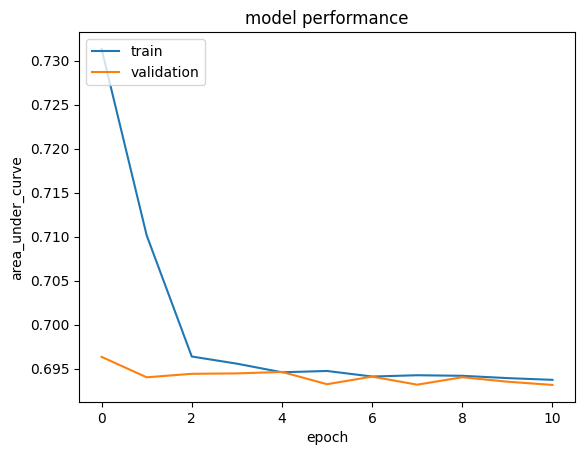

In [ ]:
plot_hist(hist, metric='loss')

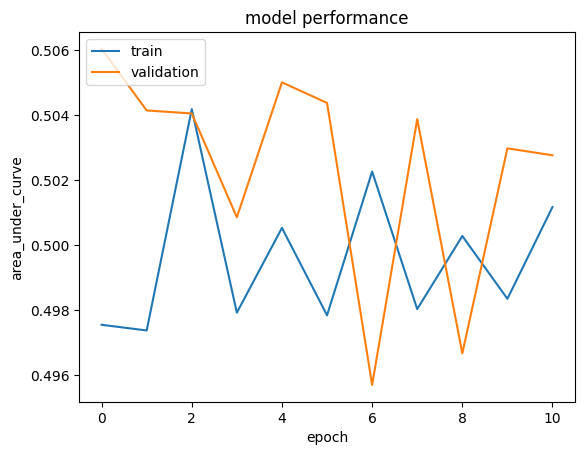

In [ ]:
plot_hist(hist)

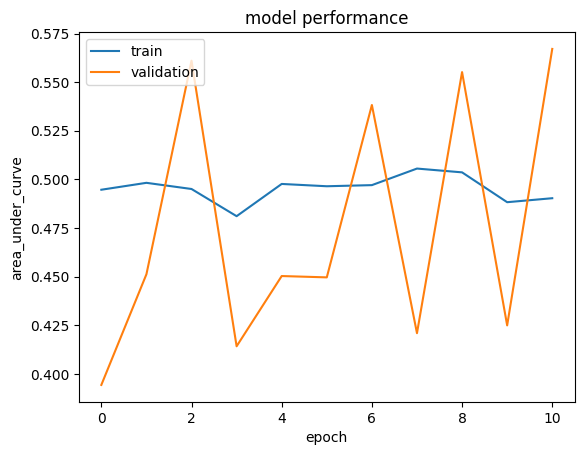

In [ ]:
plot_hist(hist, metric='f1_score')

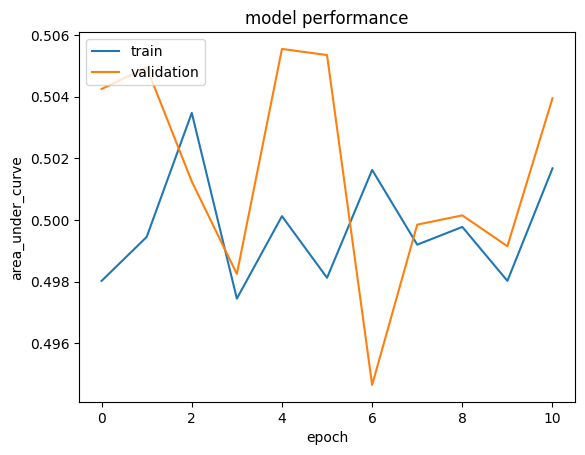

In [ ]:
plot_hist(hist, metric='accuracy')

### Hyperparameter Tuning

In [ ]:
def create_RNN_tune(embedding_dim, configuration_index, dropout, lr, num_hidden_layers, rnn_units):
    max_features, _ = configurations[configuration_index]
    model = Sequential()
    model.add(Input(shape=(1,), dtype=tf.string, name='text_input'))
    model.add(vectorize_layers[configuration_index])
    model.add(Embedding(max_features + 1, embedding_dim))
    
    # Hidden Layers (Multiple RNN layers)
    for _ in range(num_hidden_layers):
        model.add(SimpleRNN(rnn_units, return_sequences=True))
        
    # Last RNN layer (No return_sequences, producing single output vector)
    model.add(SimpleRNN(rnn_units, return_sequences = False))
    
    model.add(Dropout(dropout))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=['accuracy', f1_score, AUC(name="auc")]
    )
    return model

def tune_RNN(hp):
    vectorize_layer_ind = hp.Choice("vectorize config", values=[0, 1, 2, 3])
    dropout = hp.Float("dropout", min_value=0, max_value=0.5, step=0.1)
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    embedding_dim = hp.Int("embedding dim", min_value=64, max_value=256, step=32)
    num_hidden_layers = hp.Int("num_hidden_layers", min_value=0, max_value=3, step=1)
    rnn_units = hp.Int("rnn_units", min_value=64, max_value=256, step=32)
    
    model = create_RNN_tune(
        embedding_dim=embedding_dim, configuration_index=vectorize_layer_ind, dropout=dropout, lr=lr,
        num_hidden_layers=num_hidden_layers, rnn_units=rnn_units
    )
    return model

In [ ]:
tuner_RNN = keras_tuner.RandomSearch(
    hypermodel=tune_RNN,
    objective=keras_tuner.Objective("val_auc", "max"),
    max_trials=15,
    executions_per_trial=2,
    overwrite=False,
    directory="./working",
    project_name="rnn",
)

INFO:tensorflow:Reloading Tuner from ./working\rnn\tuner0.json


In [ ]:
tuner_RNN.search(X_train, y_train, epochs=6, validation_data=(X_test, y_test), callbacks=[es, lr, tn])

print(tuner_RNN.get_best_models()[0].summary())

# Get the best hyperparameters
best_hps = tuner_RNN.get_best_hyperparameters(num_trials=1)[0]


Trial 15 Complete [02h 40m 44s]
val_auc: 0.5049171447753906

Best val_auc So Far: 0.5352133214473724
Total elapsed time: 23h 53m 32s
INFO:tensorflow:Oracle triggered exit
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (Text  (None, 200)               0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 200, 128)          1280128   
                                                                 
 simple_rnn (SimpleRNN)      (None, 192)               61632     
                                                                 
 dropout (Dropout)           (None, 192)               0         
                                                                 
 dense (Dense)               (None, 1)                 193       
                

In [ ]:
tuner_RNN.get_best_hyperparameters()[0].values


{'vectorize config': 2,
 'dropout': 0.0,
 'lr': 0.0020620946117020753,
 'embedding dim': 128,
 'num_hidden_layers': 0,
 'rnn_units': 192}



#### Build Tuned Model

In [ ]:
## Training the best model
best_RNN = tuner_RNN.get_best_models()[0]
best_RNN.build(X_train.shape)
hist = best_RNN.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[es, lr, tn])

Epoch 1/20
1250/1250 [==============================] - 170s 134ms/step - loss: 0.6488 - accuracy: 0.5648 - f1_score: nan - auc: 0.6103 - val_loss: 0.7343 - val_accuracy: 0.5356 - val_f1_score: 0.5505 - val_auc: 0.5598 - lr: 0.0021
Epoch 2/20
1250/1250 [==============================] - 138s 110ms/step - loss: 0.6396 - accuracy: 0.5796 - f1_score: nan - auc: 0.6294 - val_loss: 0.7429 - val_accuracy: 0.5433 - val_f1_score: 0.5393 - val_auc: 0.5314 - lr: 0.0021
Epoch 3/20
1250/1250 [==============================] - 136s 109ms/step - loss: 0.6328 - accuracy: 0.5696 - f1_score: nan - auc: 0.6219 - val_loss: 0.7655 - val_accuracy: 0.5389 - val_f1_score: 0.5551 - val_auc: 0.5534 - lr: 0.0021
Epoch 4/20
1250/1250 [==============================] - 137s 110ms/step - loss: 0.6254 - accuracy: 0.5673 - f1_score: nan - auc: 0.6215 - val_loss: 0.7645 - val_accuracy: 0.5276 - val_f1_score: nan - val_auc: 0.5431 - lr: 0.0021
Epoch 5/20
1250/1250 [==============================] - 140s 112ms/step - l

##### Tuned Model Testing

In [ ]:
# Classification Report and Confusion Matrix
y_pred = best_RNN.predict(X_test)
y_pred = np.round(y_pred)
print(classification_report(y_test, y_pred))

313/313 [==============================] - 10s 31ms/step
              precision    recall  f1-score   support

           0       0.62      0.74      0.67      4999
           1       0.68      0.56      0.61      5000

    accuracy                           0.65      9999
   macro avg       0.65      0.65      0.64      9999
weighted avg       0.65      0.65      0.64      9999



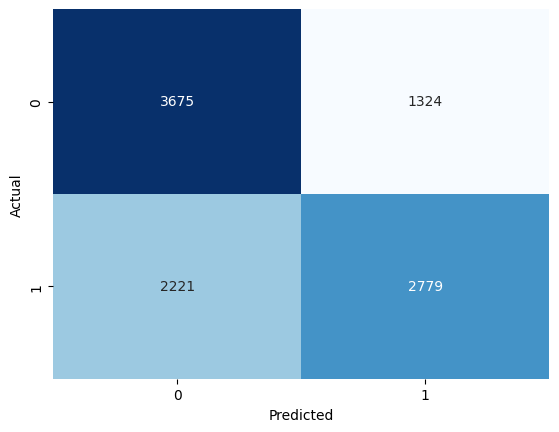

In [ ]:
plot_confusion_matrix(y_test, y_pred)

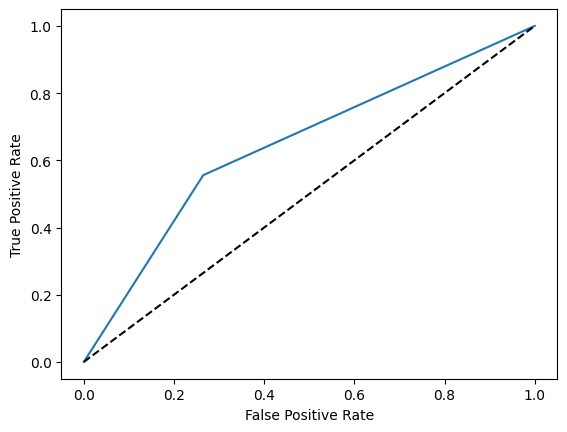

In [ ]:
plot_roc_auc(y_test, y_pred)

##### Tuned Model History

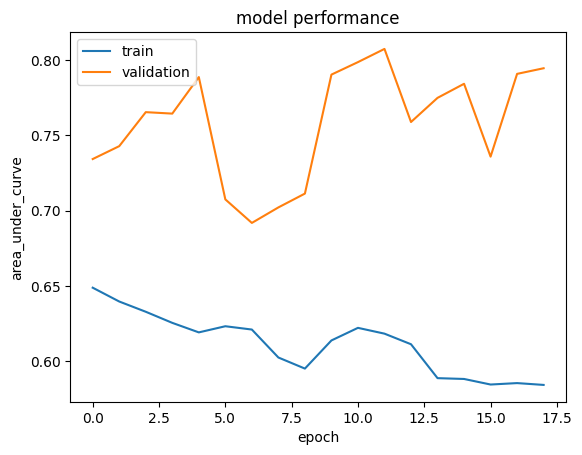

In [ ]:
plot_hist(hist, metric='loss')

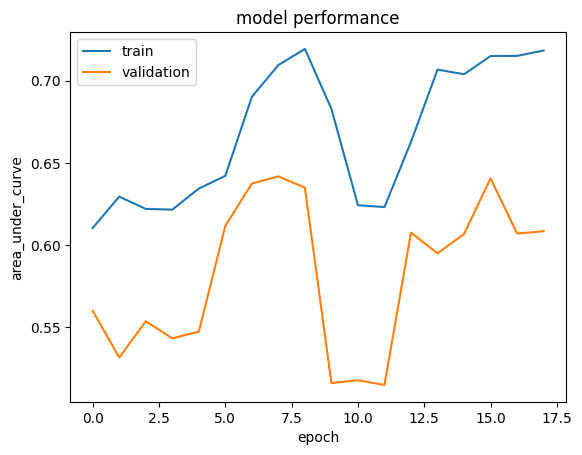

In [ ]:
plot_hist(hist)

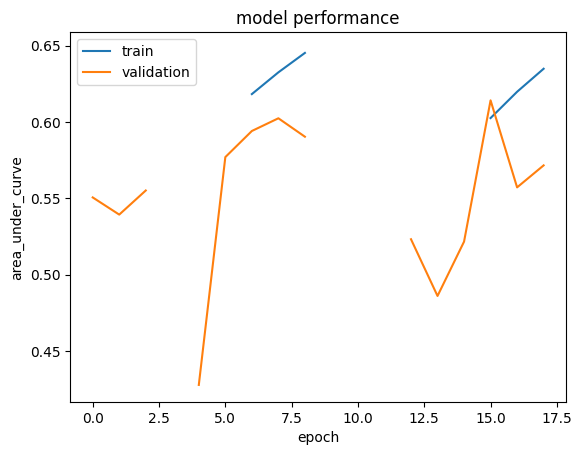

In [ ]:
plot_hist(hist, metric='f1_score')

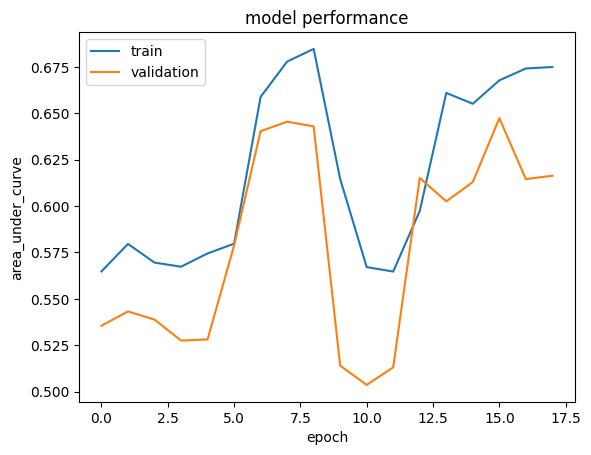

In [ ]:
plot_hist(hist, metric='accuracy')

##### Save Best RNN

In [ ]:
#  save model 
best_RNN.save("./models/best_rnn_model")

INFO:tensorflow:Assets written to: ./models/best_rnn_model\assets


INFO:tensorflow:Assets written to: ./models/best_rnn_model\assets


## GRU

In [22]:
def create_gru_tune(units, dropout, lr, embedding_dim, configuration_index):
    max_features, _ = configurations[configuration_index]
    model = Sequential()
    model.add(Input(shape=(1,), dtype=tf.string, name='text'))
    model.add(vectorize_layers[configuration_index])
    model.add(Embedding(max_features + 1, embedding_dim))
    if dropout:
        model.add(Dropout(rate=0.5))
    model.add(GRU(units=units))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=['accuracy', f1_score, AUC()]
    )
    return model


def tune_gru(hp):
    units = hp.Int("units", min_value=32, max_value=512, step=32)
    vectorize_layer_ind = hp.Int("vectorize config", min_value=0, max_value=3, step=1)
    dropout = hp.Boolean("dropout")
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    embedding_dim = hp.Int("embedding dim", min_value=64, max_value=256, step=32)
    
    # call existing model-building code with the hyperparameter values.
    model = create_gru_tune(
        units=units, dropout=dropout, lr=lr, configuration_index=vectorize_layer_ind, embedding_dim=embedding_dim
    )
    return model

### Initial Model

In [23]:
initial_gru_model = create_gru_tune(units=64, dropout= True, lr=0.005, embedding_dim=128, configuration_index=0)
initial_gru_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 500)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 500, 128)          2560128   
                                                                 
 dropout (Dropout)           (None, 500, 128)          0         
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2,597,441
Trainable params: 2,597,441
Non-trainable params: 0
______________________________________________

In [24]:
hist = initial_gru_model.fit(X_train, y_train, epochs=20, batch_size=128, callbacks=[lr, es], validation_data=(X_test, y_test))

Epoch 1/20
313/313 [==============================] - 435s 1s/step - loss: 0.6936 - accuracy: 0.5009 - f1_score: nan - auc: 0.4994 - val_loss: 0.6932 - val_accuracy: 0.5008 - val_f1_score: nan - val_auc: 0.4994 - lr: 0.0050
Epoch 2/20
313/313 [==============================] - 435s 1s/step - loss: 0.6933 - accuracy: 0.5007 - f1_score: nan - auc: 0.4993 - val_loss: 0.6933 - val_accuracy: 0.4991 - val_f1_score: 0.6650 - val_auc: 0.4992 - lr: 0.0050
Epoch 3/20
313/313 [==============================] - 444s 1s/step - loss: 0.6925 - accuracy: 0.4997 - f1_score: nan - auc: 0.5009 - val_loss: 0.6939 - val_accuracy: 0.4995 - val_f1_score: 0.6648 - val_auc: 0.5011 - lr: 0.0050
Epoch 4/20
313/313 [==============================] - 458s 1s/step - loss: 0.6905 - accuracy: 0.5061 - f1_score: nan - auc: 0.5089 - val_loss: 0.6957 - val_accuracy: 0.5007 - val_f1_score: nan - val_auc: 0.4996 - lr: 0.0050
Epoch 5/20
313/313 [==============================] - 458s 1s/step - loss: 0.6900 - accuracy: 0.50

#### Model Testing

In [25]:
# Classification Report and Confusion Matrix
y_pred = initial_gru_model.predict(X_test)
y_pred = np.round(y_pred)
print(classification_report(y_test, y_pred))

313/313 [==============================] - 13s 40ms/step
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      4999
           1       0.90      0.83      0.86      5000

    accuracy                           0.87      9999
   macro avg       0.87      0.87      0.87      9999
weighted avg       0.87      0.87      0.87      9999



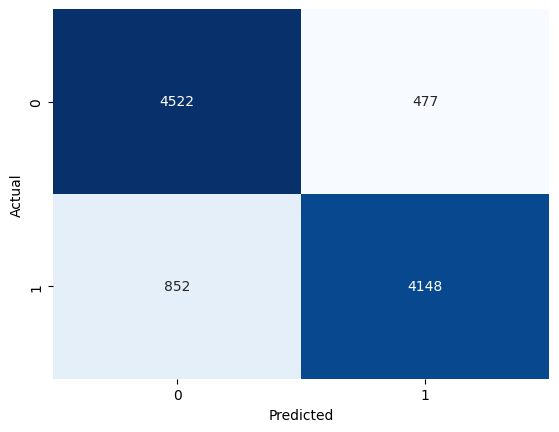

In [26]:
plot_confusion_matrix(y_test, y_pred)

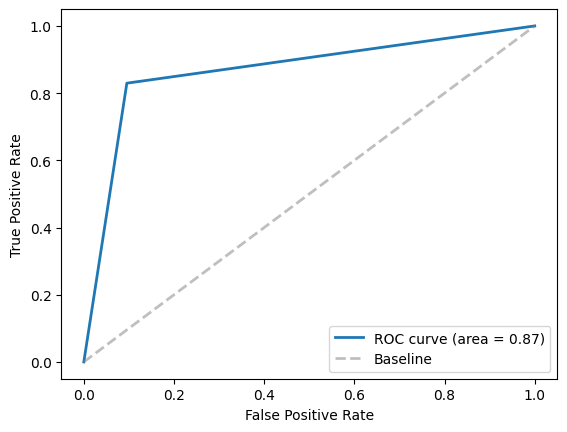

In [33]:
plot_roc_auc(y_test, y_pred)

#### Model History

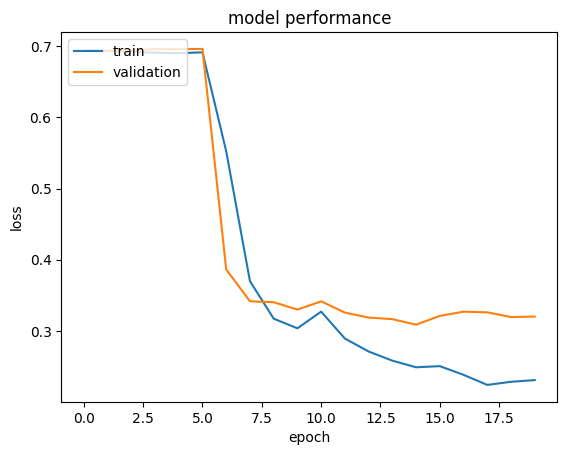

In [27]:
plot_hist(hist, metric='loss')

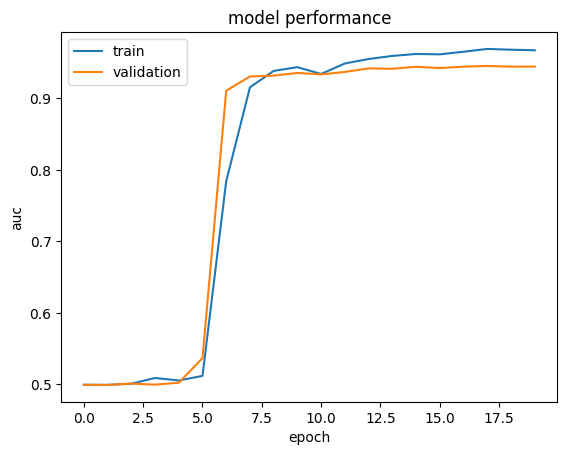

In [28]:
plot_hist(hist)

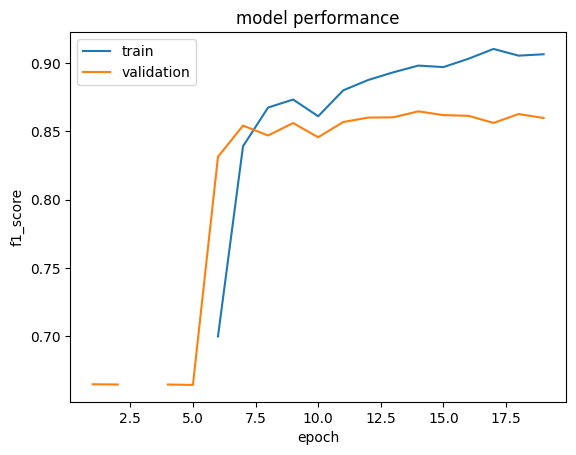

In [30]:
plot_hist(hist, metric='f1_score')

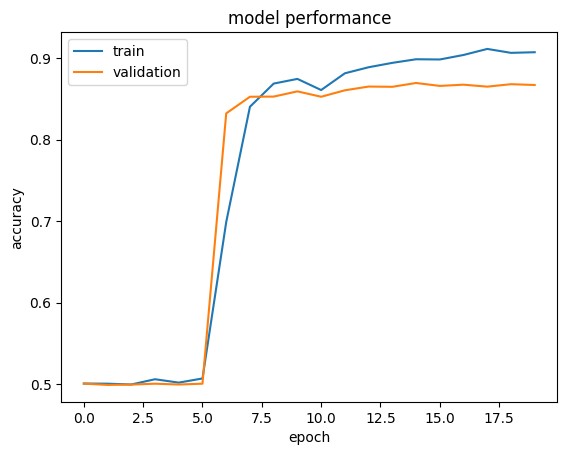

In [31]:
plot_hist(hist, metric='accuracy')

### Hyperparameter Tuning

In [ ]:
tuner_gru = keras_tuner.RandomSearch(
    hypermodel=tune_gru,
    objective=keras_tuner.Objective("val_auc", "max"),
    max_trials=10,
    executions_per_trial=2,
    overwrite=False,
    directory="./working",
    project_name="gru",
)

tuner_gru.search(X_train, y_train, epochs=6, validation_data=(X_test, y_test), callbacks=[es, lr, tn])

print(tuner_gru.get_best_models()[0].summary())

Trial 10 Complete [00h 13m 49s]
val_auc: 0.509309321641922

Best val_auc So Far: 0.959471195936203
Total elapsed time: 00h 50m 37s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, 200)              0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 200, 64)           640064    
                                                                 
 dropout (Dropout)           (None, 200, 64)           0         
                                                                 
 gru (GRU)                   (None, 32)                9408      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                         

In [ ]:
tuner_gru.get_best_hyperparameters(num_trials=1)[0].values

{'units': 32,
 'vectorize config': 2,
 'dropout': True,
 'lr': 0.0028209709086056147,
 'embedding dim': 64}

#### Build Tuned Model

In [ ]:
best_gru = tuner_gru.get_best_models()[0]
best_gru.build(X_train.shape)
hist = best_gru.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[es,lr, tn])

Epoch 1/10
1250/1250 [==============================] - 105s 82ms/step - loss: 0.1597 - accuracy: 0.9405 - f1_score: 0.9389 - auc: 0.9834 - val_loss: 0.2772 - val_accuracy: 0.8904 - val_f1_score: 0.8894 - val_auc: 0.9580 - lr: 0.0028
Epoch 2/10
1250/1250 [==============================] - 32s 26ms/step - loss: 0.1254 - accuracy: 0.9552 - f1_score: 0.9539 - auc: 0.9892 - val_loss: 0.3593 - val_accuracy: 0.8812 - val_f1_score: 0.8855 - val_auc: 0.9529 - lr: 0.0028
Epoch 3/10
1250/1250 [==============================] - 30s 24ms/step - loss: 0.1026 - accuracy: 0.9641 - f1_score: 0.9631 - auc: 0.9925 - val_loss: 0.3233 - val_accuracy: 0.8893 - val_f1_score: 0.8873 - val_auc: 0.9535 - lr: 0.0028
Epoch 4/10
1250/1250 [==============================] - 24s 19ms/step - loss: 0.0876 - accuracy: 0.9691 - f1_score: 0.9679 - auc: 0.9943 - val_loss: 0.3554 - val_accuracy: 0.8878 - val_f1_score: 0.8838 - val_auc: 0.9506 - lr: 0.0028
Epoch 5/10
1250/1250 [==============================] - 24s 19ms/st

##### Tuned Model History

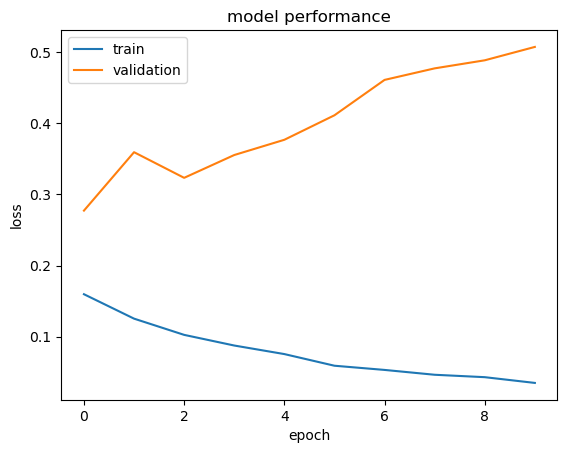

In [ ]:
plot_hist(hist, metric='loss')

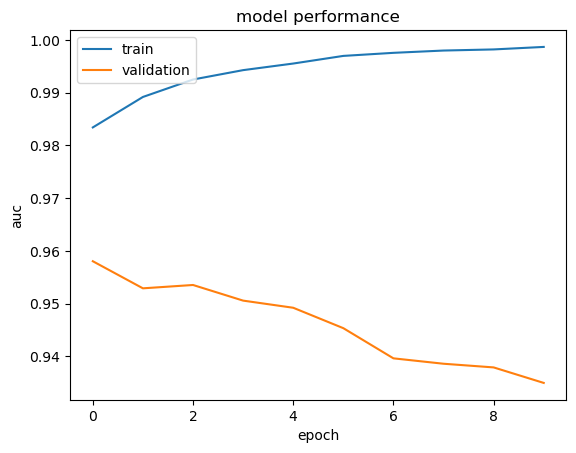

In [ ]:
plot_hist(hist)

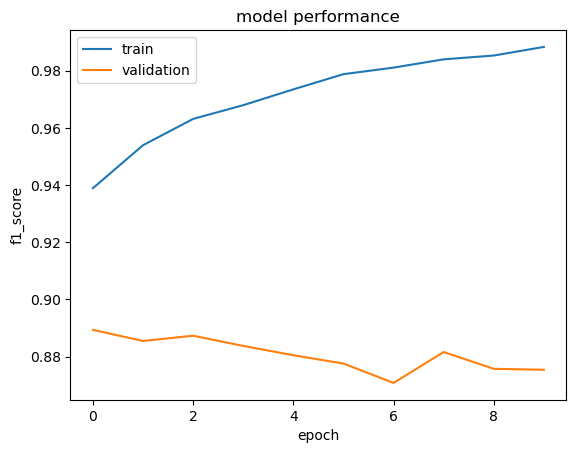

In [ ]:
plot_hist(hist, metric='f1_score')

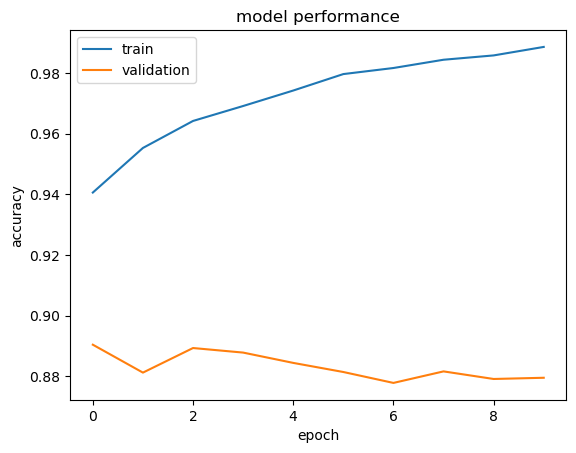

In [ ]:
plot_hist(hist, metric='accuracy')

 - History shows that epoch 0 (model that is from the tuner), is the best as after that it starts to overfit.

##### Tuned Model Testing

In [ ]:
best_gru = tuner_gru.get_best_models()[0]
# Classification Report and Confusion Matrix
y_pred = best_gru.predict(X_test)
y_pred = np.round(y_pred)
print(classification_report(y_test, y_pred))

313/313 [==============================] - 2s 6ms/step
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      4999
           1       0.93      0.84      0.88      5000

    accuracy                           0.89      9999
   macro avg       0.89      0.89      0.89      9999
weighted avg       0.89      0.89      0.89      9999



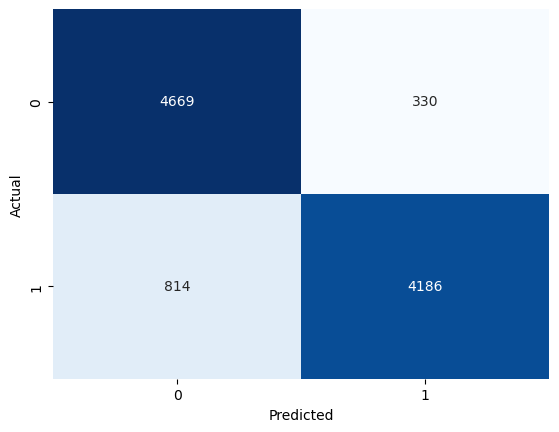

In [ ]:
plot_confusion_matrix(y_test, y_pred)

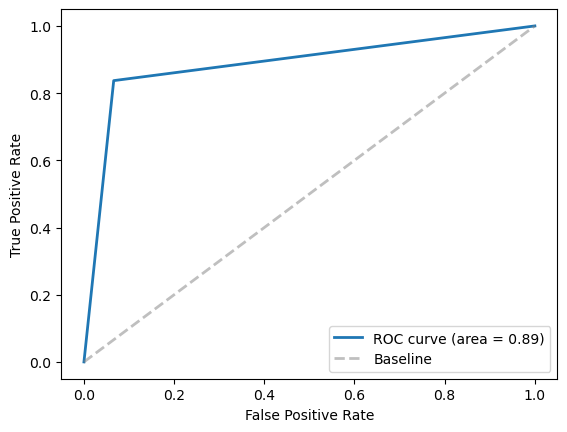

In [ ]:
plot_roc_auc(y_test, y_pred)

In [ ]:
best_gru.save("./models/best_gru_model")